In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
os.getcwd()

'C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\notebooks'

In [4]:
def load_yearwise_data(filepath, years, skiprows=1):
    dfs = []
    
    for year in years:
        df = pd.read_excel(filepath, sheet_name=str(year), skiprows=skiprows)

        # Check if expected columns exist
        expected_cols = ['Pathogen', 'Frequency Count', 'Percent of Total Frequency']
        if all(col in df.columns for col in expected_cols):
            df = df[expected_cols]
            df['Year'] = year
            dfs.append(df)
        else:
            print(f"Warning: Sheet for {year} does not match expected column names.")
            print("Found columns:", df.columns.tolist())

    # Combine all valid sheets
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        raise ValueError("No sheets could be loaded due to column mismatch.")


    

In [5]:
filepath = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\pathogen_trends\\2018-2021-adult-pathogen-distributions.xlsx"
years = [2018, 2019, 2020, 2021]

adult_yearly_df = load_yearwise_data(filepath, years)
print(adult_yearly_df.head())

                 Pathogen  Frequency Count Percent of Total Frequency  Year
0        Escherichia coli            19411                  17.314554  2018
1   Staphylococcus aureus            13566                  12.100831  2018
2   Enterococcus faecalis             8938                   7.972669  2018
3  Pseudomonas aeruginosa             8905                   7.943233  2018
4   Klebsiella pneumoniae             7208                   6.429514  2018


In [6]:
adult_yearly_df.shape

(2861, 4)

In [7]:
filepath = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\pathogen_trends\\2018-2021-pediatric-pathogen-distributions.xlsx"
years = [2018, 2019, 2020, 2021]

pediatric_yearly_df = load_yearwise_data(filepath, years)
print(adult_yearly_df.head())

                 Pathogen  Frequency Count Percent of Total Frequency  Year
0        Escherichia coli            19411                  17.314554  2018
1   Staphylococcus aureus            13566                  12.100831  2018
2   Enterococcus faecalis             8938                   7.972669  2018
3  Pseudomonas aeruginosa             8905                   7.943233  2018
4   Klebsiella pneumoniae             7208                   6.429514  2018


In [8]:
#Adding a popluation group column to both the dataframes
adult_yearly_df['Population Group'] = 'Adult'
pediatric_yearly_df['Population Group'] = 'Pediatric'

In [9]:
#Combining the adult and pediatric dataframes
yearly_df = pd.concat([adult_yearly_df, pediatric_yearly_df], ignore_index = True)

In [10]:
yearly_df.head()

,Pathogen,Frequency Count,Percent of Total Frequency,Year,Population Group
0,Escherichia coli,19411,17.314554,2018,Adult
1,Staphylococcus aureus,13566,12.100831,2018,Adult
2,Enterococcus faecalis,8938,7.972669,2018,Adult
3,Pseudomonas aeruginosa,8905,7.943233,2018,Adult
4,Klebsiella pneumoniae,7208,6.429514,2018,Adult


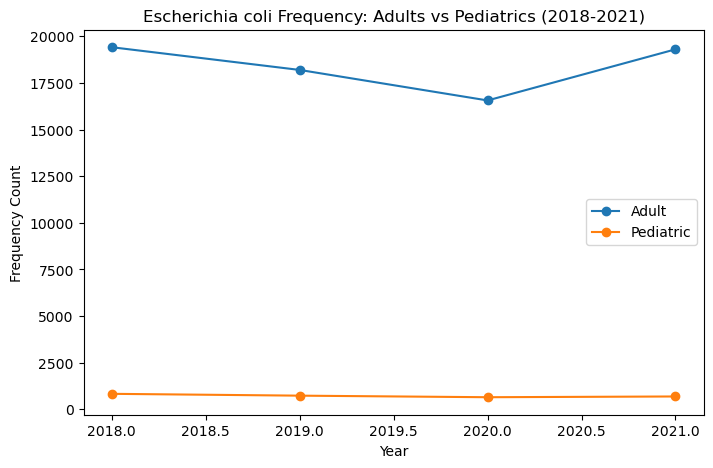

In [11]:

#Focusing on a target pathogen like E. coli
target_pathogen = 'Escherichia coli'
subset = yearly_df[yearly_df['Pathogen'] == target_pathogen]

#Plot
plt.figure(figsize=(8,5))
for group in subset['Population Group'].unique():
    group_data = subset[subset['Population Group'] == group]
    plt.plot(group_data['Year'], group_data['Frequency Count'], marker = 'o', label = group)

plt.title(f"{target_pathogen} Frequency: Adults vs Pediatrics (2018-2021)")
plt.xlabel('Year')
plt.ylabel('Frequency Count')
plt.legend()
plt.show()



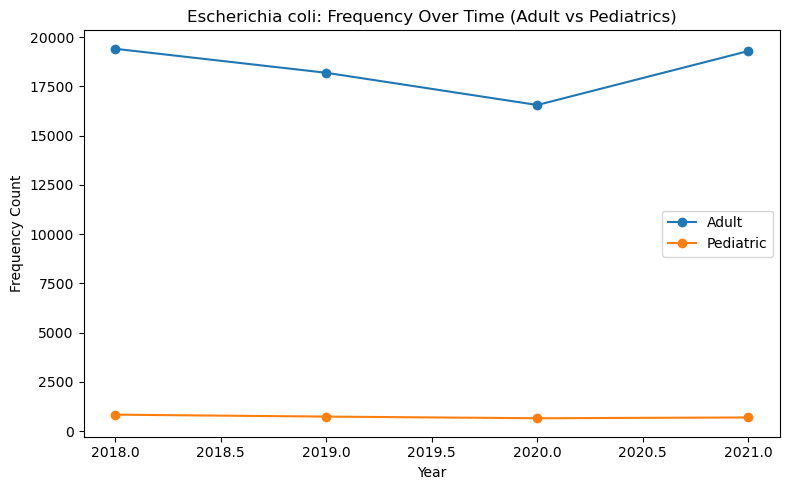

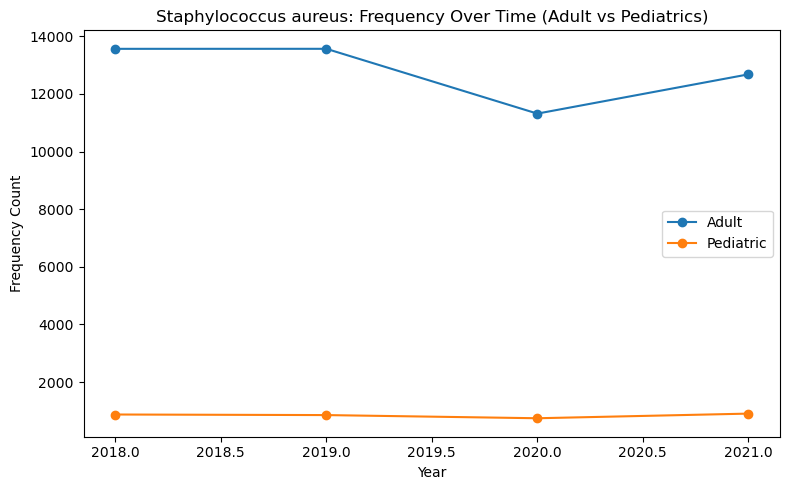

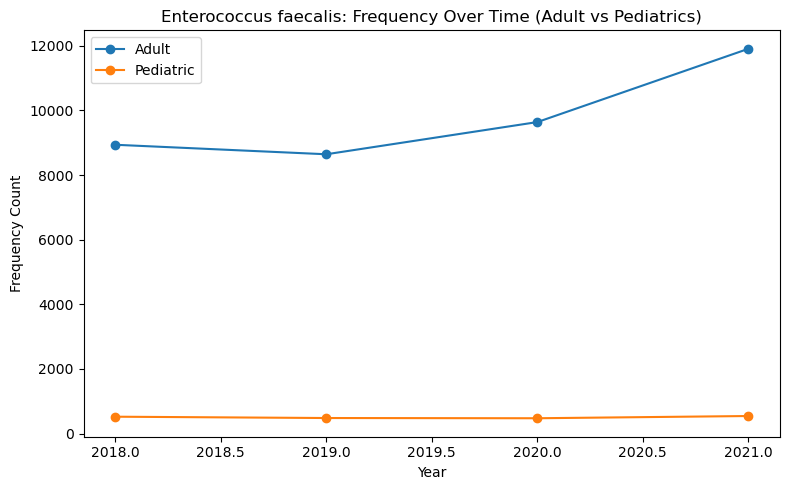

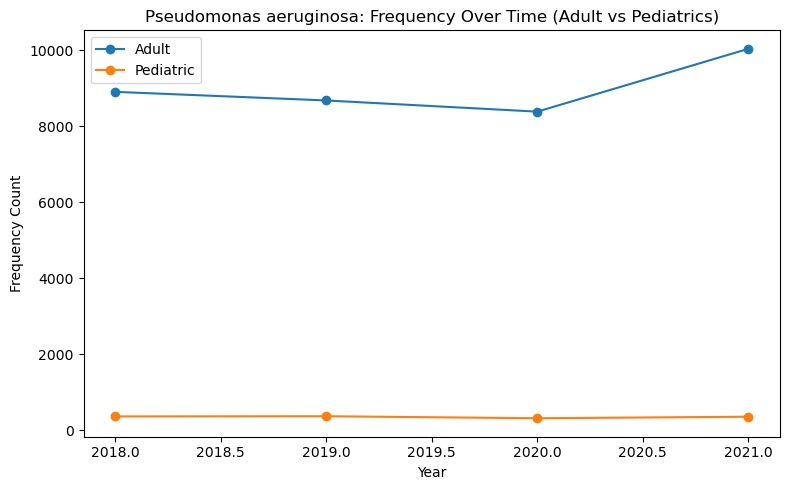

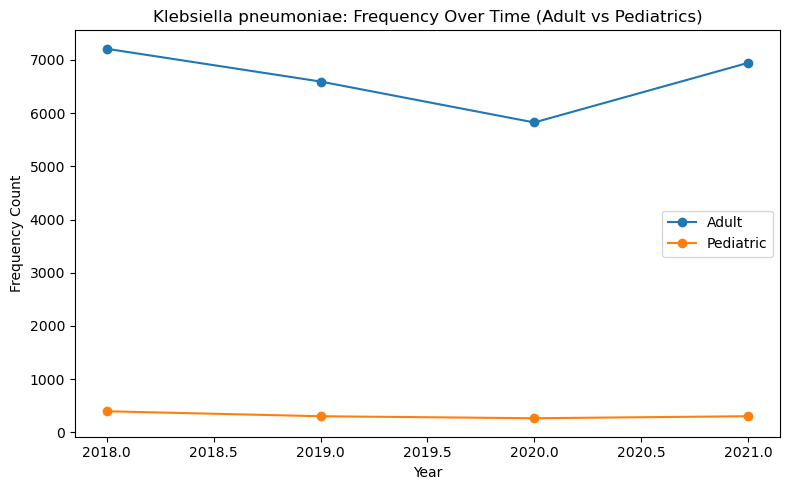

In [12]:
#Graphs for top 5 pathogens
#Creating a group of top 5 pathogens
top_5_pathogens = (
    yearly_df.groupby('Pathogen')['Frequency Count']
    .sum()
    .sort_values(ascending = False)
    .head(5)
    .index.tolist()
)

#Loop through each pathogen and plot its trend for both the groups
for pathogen in top_5_pathogens:
    #Filter data for this specific pathogen
    pathogen_data = yearly_df[yearly_df['Pathogen'] == pathogen]
    #Create a new figure for each pathogen
    plt.figure(figsize=(8,5))
    #Plot trends for both groups
    for group in ['Adult', 'Pediatric']:
        group_data = pathogen_data[pathogen_data['Population Group'] == group]
        plt.plot(group_data['Year'], group_data['Frequency Count'], marker = 'o', label = group)
    #Graph details
    plt.title(f"{pathogen}: Frequency Over Time (Adult vs Pediatrics)")
    plt.xlabel('Year')
    plt.ylabel('Frequency Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [14]:
from prophet import Prophet

#Filter the data for E. coli (Adult) only
ecoli_adult = yearly_df[
    (yearly_df['Pathogen'] == 'Escherichia coli') &
    (yearly_df['Population Group'] == 'Adult')
][['Year', 'Frequency Count']].copy()

#Rename for prophet
ecoli_adult = ecoli_adult.rename(columns = {'Year': 'ds', 'Frequency Count': 'y'})

#Convert year to datetime
ecoli_adult['ds'] = pd.to_datetime(ecoli_adult['ds'], format = '%Y')

In [15]:
#Initialize and fit the model 
model = Prophet()
model.fit(ecoli_adult)

#Make future dataframe (predict 3 years)
future = model.make_future_dataframe(periods=3, freq='YE')

#Forecast
forecast = model.predict(future)

15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] done processing


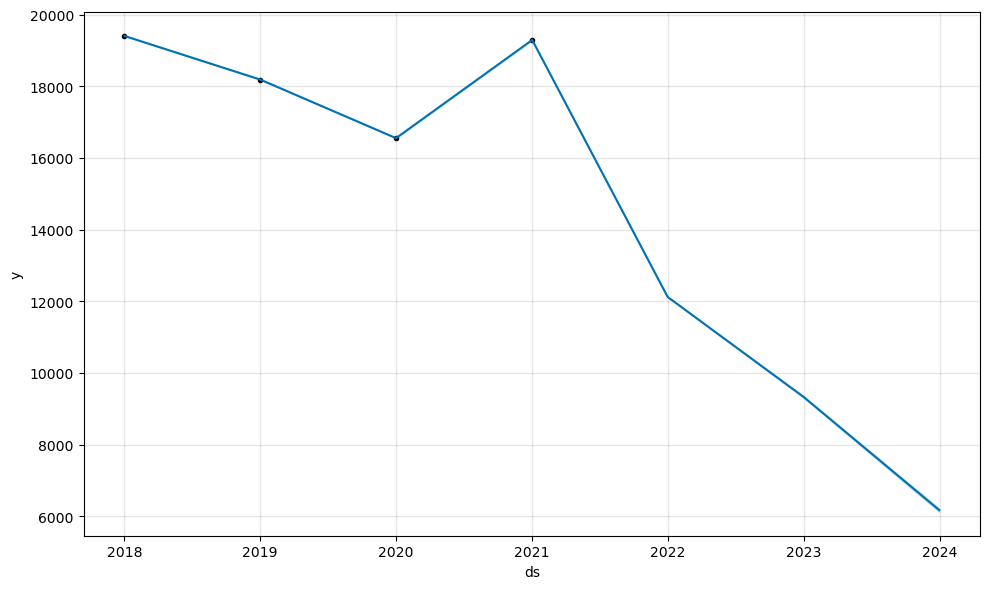

In [16]:
fig = model.plot(forecast)

In [17]:
#Creating a function for forecasting future trends for top 5 pathogens
def forecast_top_pathogens(df, top_pathogens, population_group='Adult', years_to_predict=3):
    """
    Forecast future trends for top pathogens in a given population group using Prophet.

    Parameters:
    - df: DataFrame with pathogen data
    - top_pathogens: list of pathogen names
    - population_group: 'Adult' or 'Pediatric'
    - years_to_predict: number of years into the future to forecast
    """
    for pathogen in top_pathogens:
        # Filter data
        subset = df[
            (df['Pathogen'] == pathogen) &
            (df['Population Group'] == population_group)
        ][['Year', 'Frequency Count']].copy()

        # Skip if not enough data
        if subset.shape[0] < 2:
            print(f"⚠️ Skipping {pathogen} due to insufficient data.")
            continue

        # Rename for Prophet
        subset = subset.rename(columns={'Year': 'ds', 'Frequency Count': 'y'})
        subset['ds'] = pd.to_datetime(subset['ds'], format='%Y')

        # Train Prophet model
        model = Prophet()
        model.fit(subset)

        # Forecast
        future = model.make_future_dataframe(periods=years_to_predict, freq='Y')
        forecast = model.predict(future)

        # Plot
        print(f"\n🔮 Forecast for {pathogen} ({population_group})")
        fig = model.plot(forecast)
        plt.title(f"{pathogen} ({population_group}) - Forecast")
        plt.xlabel("Year")
        plt.ylabel("Frequency Count")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



🔮 Forecast for Escherichia coli (Adult)


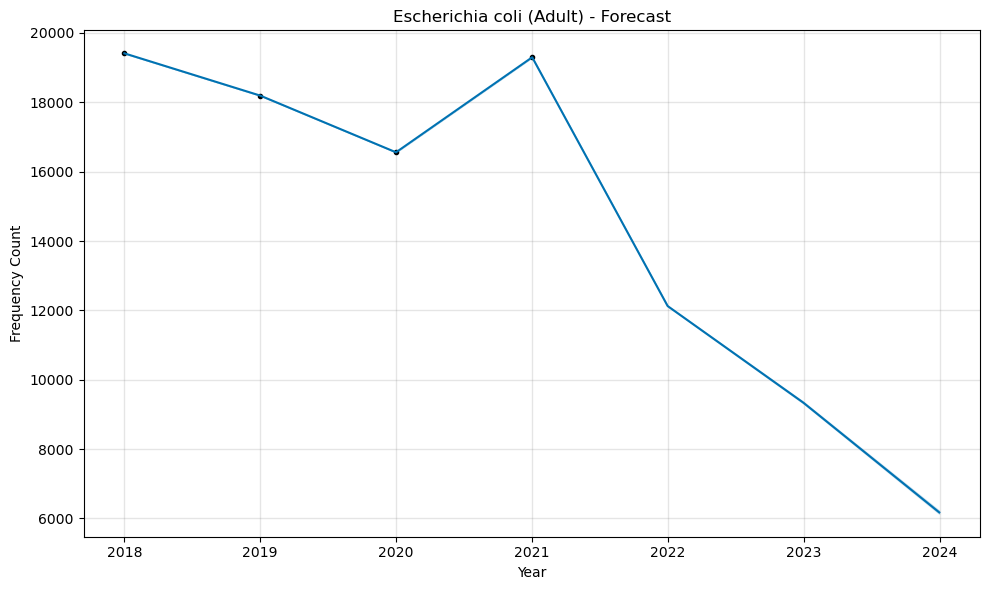

15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



🔮 Forecast for Staphylococcus aureus (Adult)


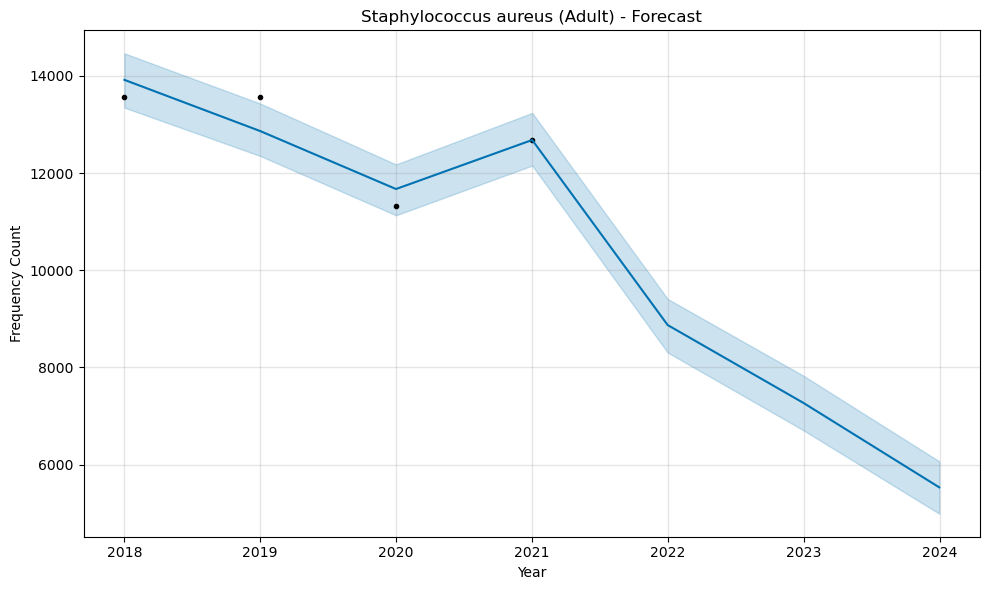

15:08:53 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



🔮 Forecast for Enterococcus faecalis (Adult)


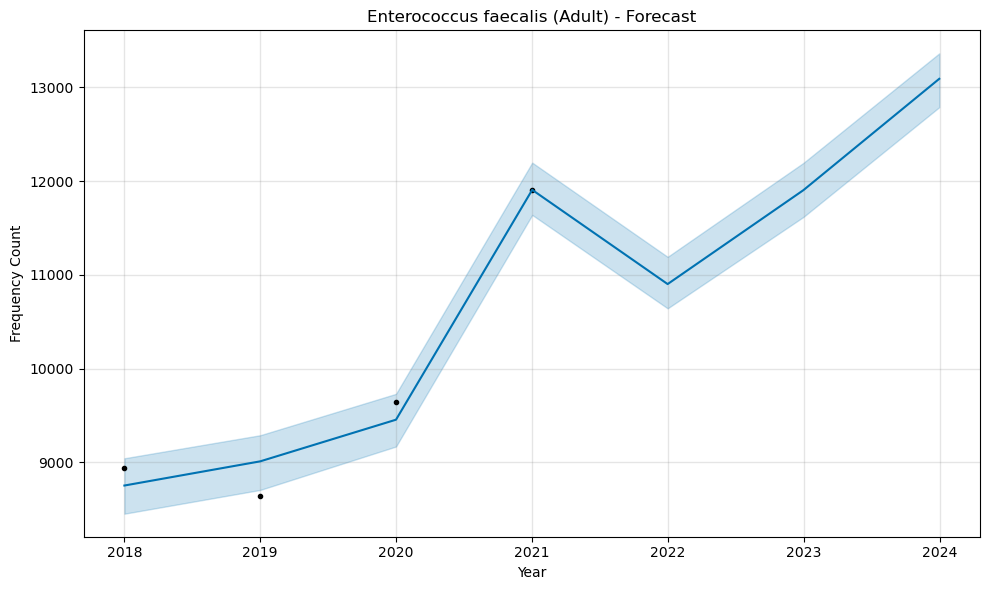

15:08:54 - cmdstanpy - INFO - Chain [1] start processing
15:08:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



🔮 Forecast for Pseudomonas aeruginosa (Adult)


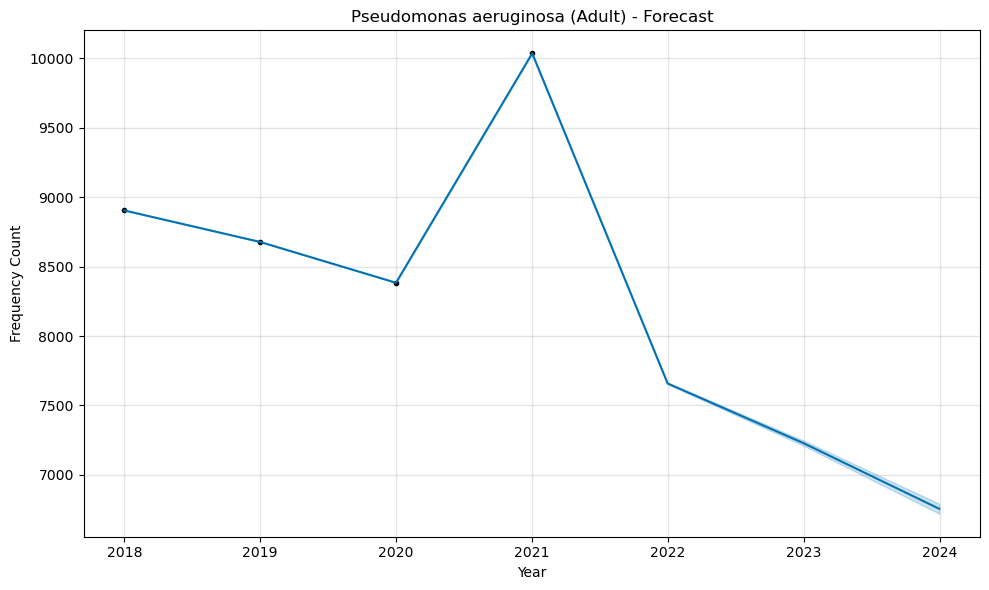

15:08:54 - cmdstanpy - INFO - Chain [1] start processing
15:08:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\HP\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



🔮 Forecast for Klebsiella pneumoniae (Adult)


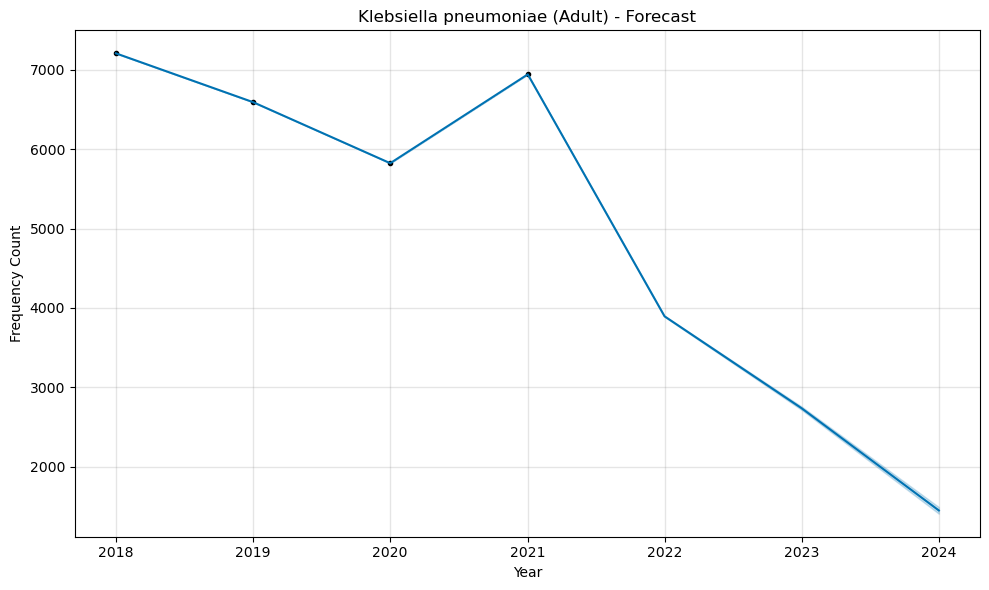

In [18]:
# Example: Forecast top 5 pathogens for Adult population
forecast_top_pathogens(yearly_df, top_5_pathogens, population_group='Adult', years_to_predict=3)

In [19]:
# Example: Forecast top 5 pathogens for Adult population
forecast_top_pathogens(yearly_df, top_5_pathogens, population_group='Pediatrics', years_to_predict=3) #This shows insufficient data for prediatrics age group

⚠️ Skipping Escherichia coli due to insufficient data.
⚠️ Skipping Staphylococcus aureus due to insufficient data.
⚠️ Skipping Enterococcus faecalis due to insufficient data.
⚠️ Skipping Pseudomonas aeruginosa due to insufficient data.
⚠️ Skipping Klebsiella pneumoniae due to insufficient data.


GLASS AMU Data for antimicrobial use

In [20]:
#Loading the dataset
filepath = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\antimicrobial_use\\GLASS-AMU_2016-22_dataset.xlsx"

amu_data = pd.read_excel(filepath, sheet_name='Antimicrobial_Use_ATC4')
amu_data.head()

,WHORegionCode,WHORegionName,CountryIso3,CountryTerritoryArea,IncomeWorldBankJune,Year,AntimicrobialClass,ATC4,ATC4Name,RouteOfAdministration,DDD,DID,Notes
0,EUR,European Region,ARM,Armenia,Upper middle income,2022,"Antibacterials (ATC J01, A07AA, P01AB)",A07AA,Antibiotics (A07AA),O,38559.33333,0.037994,NaN
1,EUR,European Region,ARM,Armenia,Upper middle income,2022,"Antibacterials (ATC J01, A07AA, P01AB)",J01AA,Tetracyclines (J01AA),O,967786.00000,0.953604,NaN
2,EUR,European Region,ARM,Armenia,Upper middle income,2022,"Antibacterials (ATC J01, A07AA, P01AB)",J01BA,Amphenicols (J01BA),O,186066.66670,0.183340,NaN
3,EUR,European Region,ARM,Armenia,Upper middle income,2022,"Antibacterials (ATC J01, A07AA, P01AB)",J01BA,Amphenicols (J01BA),P,780.00000,0.000769,NaN
4,EUR,European Region,ARM,Armenia,Upper middle income,2022,"Antibacterials (ATC J01, A07AA, P01AB)",J01CA,Penicillins with extended spectrum (J01CA),O,323153.33330,0.318418,NaN


In [21]:
amu_data.shape

(18126, 13)

In [22]:
amu_data.to_csv('amu_data.csv')

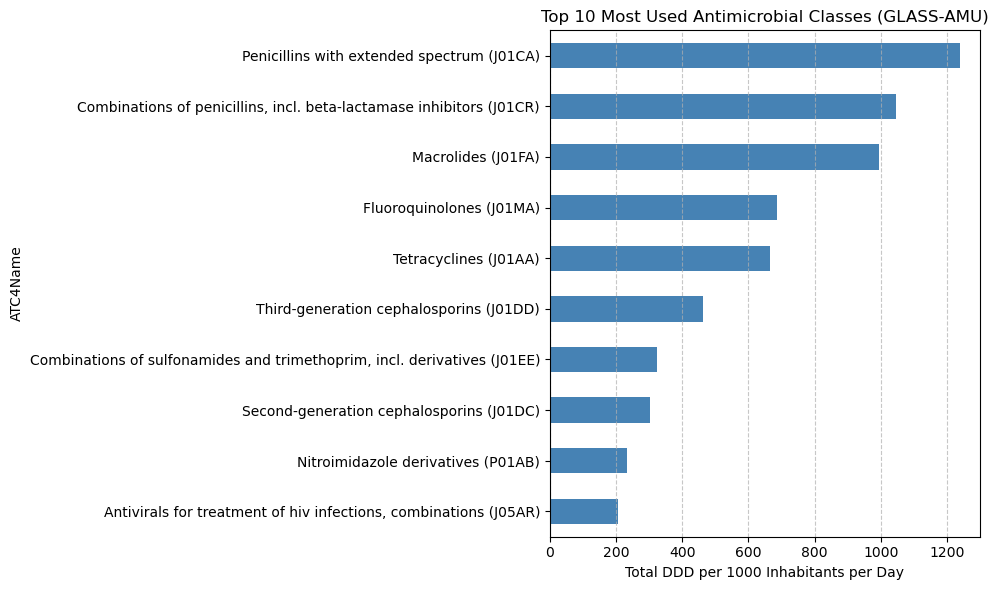

In [23]:
# Group and sum DID (DDD per 1000 inhabitants per day) across all years and countries
top_atc_classes = (
    amu_data.groupby('ATC4Name')['DID']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(10, 6))
top_atc_classes.plot(kind='barh', color='steelblue')
plt.xlabel("Total DDD per 1000 Inhabitants per Day")
plt.title("Top 10 Most Used Antimicrobial Classes (GLASS-AMU)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


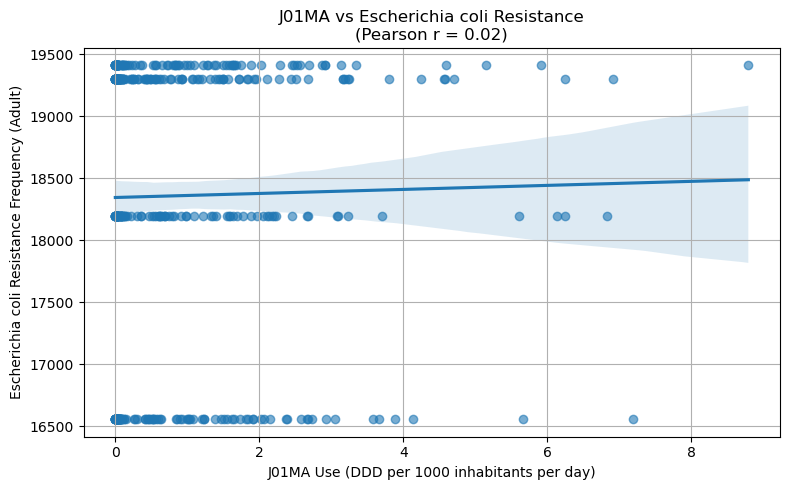

In [24]:
from scipy.stats import pearsonr

def correlate_amu_resistance(amu_df, resistance_df, atc4_code, pathogen_name, population_group='Adult'):
    """
    Correlate AMU (by ATC4 code) with resistance frequency (by pathogen).
    """
    # Step 1: Filter AMU data for specific ATC4 code (e.g., J01MA - Fluoroquinolones)
    amu_filtered = amu_df[amu_df['ATC4'] == atc4_code][['CountryTerritoryArea', 'Year', 'DID']].copy()
    amu_filtered = amu_filtered.rename(columns={
        'CountryTerritoryArea': 'Country',
        'DID': 'Drug_Use'
    })

    # Step 2: Filter resistance data for specific pathogen & population group
    resistance_filtered = resistance_df[
        (resistance_df['Pathogen'] == pathogen_name) &
        (resistance_df['Population Group'] == population_group)
    ][['Year', 'Frequency Count']].groupby('Year').sum().reset_index()
    resistance_filtered = resistance_filtered.rename(columns={'Frequency Count': 'Resistance_Frequency'})

    # Step 3: Merge on Year (resistance is global-level; AMU is country-level)
    merged = pd.merge(amu_filtered, resistance_filtered, on='Year', how='inner')

    # Step 4: Plot and correlate
    plt.figure(figsize=(8, 5))
    sns.regplot(data=merged, x='Drug_Use', y='Resistance_Frequency', scatter_kws={'alpha':0.6})

    # Calculate Pearson correlation
    corr, _ = pearsonr(merged['Drug_Use'], merged['Resistance_Frequency'])

    plt.title(f'{atc4_code} vs {pathogen_name} Resistance\n(Pearson r = {corr:.2f})')
    plt.xlabel(f'{atc4_code} Use (DDD per 1000 inhabitants per day)')
    plt.ylabel(f'{pathogen_name} Resistance Frequency ({population_group})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return merged  # Optionally return the merged dataset

# 🧪 Example usage:
merged_result = correlate_amu_resistance(
    amu_df=amu_data,
    resistance_df=adult_yearly_df,
    atc4_code='J01MA',  # Fluoroquinolones
    pathogen_name='Escherichia coli',
    population_group='Adult'
)


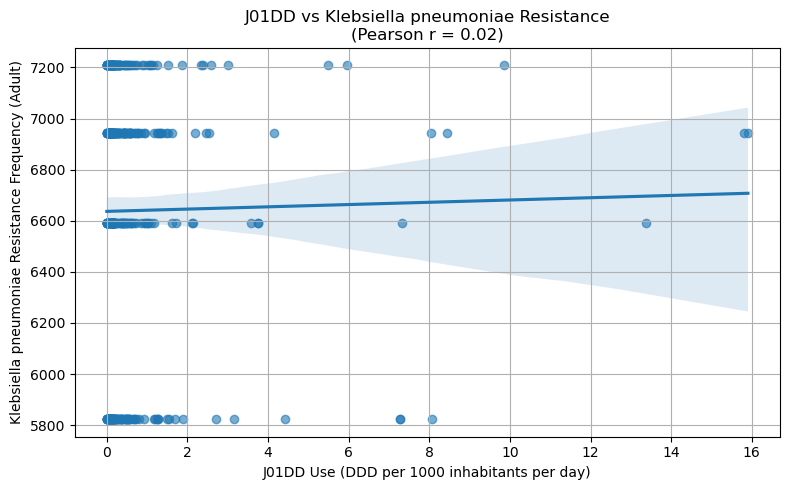

,Country,Year,Drug_Use,Resistance_Frequency
0,Armenia,2021,0.428282,6943
1,Armenia,2021,1.358076,6943
2,Armenia,2020,0.439605,5824
3,Armenia,2020,1.266029,5824
4,Armenia,2019,0.251408,6593
...,...,...,...,...
364,Ukraine,2018,1.236294,7208
365,South Africa,2021,0.745369,6943
366,South Africa,2020,0.570858,5824
367,South Africa,2019,0.469521,6593


In [25]:
correlate_amu_resistance(amu_data, adult_yearly_df, 'J01DD', 'Klebsiella pneumoniae')


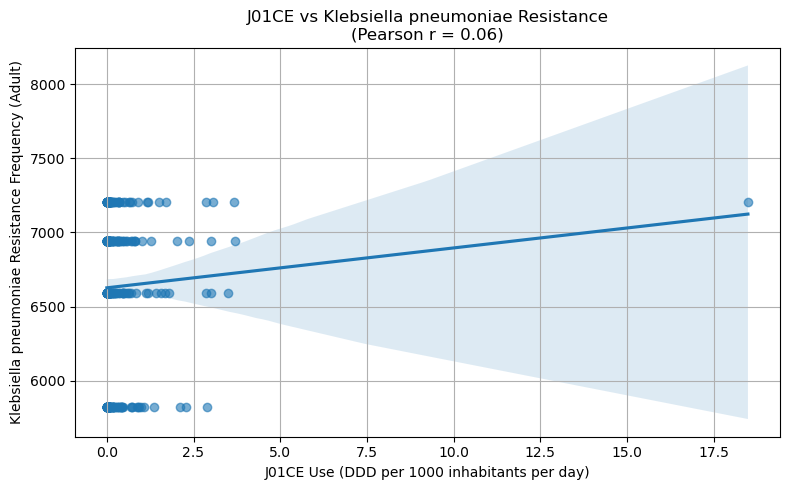

,Country,Year,Drug_Use,Resistance_Frequency
0,Armenia,2021,0.013972,6943
1,Armenia,2020,0.071838,5824
2,Armenia,2019,0.093085,6593
3,Armenia,2018,0.073797,7208
4,Austria,2021,0.296994,6943
...,...,...,...,...
333,Ukraine,2018,0.026108,7208
334,South Africa,2021,0.311351,6943
335,South Africa,2020,0.354604,5824
336,South Africa,2019,0.362343,6593


In [26]:
# Correlate 3rd-gen cephalosporin usage with Klebsiella pneumoniae resistance
correlate_amu_resistance(
    amu_df=amu_data,
    resistance_df=adult_yearly_df,
    atc4_code='J01CE',  
    pathogen_name='Klebsiella pneumoniae',
    population_group='Adult'
)


In [27]:
def correlate_amu_resistance_return_r(amu_df, resistance_df, atc4_code, pathogen_name, population_group='Adult'):
    amu_filtered = amu_df[amu_df['ATC4'] == atc4_code][['CountryTerritoryArea', 'Year', 'DID']].copy()
    amu_filtered = amu_filtered.rename(columns={
        'CountryTerritoryArea': 'Country',
        'DID': 'Drug_Use'
    })

    resistance_filtered = resistance_df[
        (resistance_df['Pathogen'] == pathogen_name) &
        (resistance_df['Population Group'] == population_group)
    ][['Year', 'Frequency Count']].groupby('Year').sum().reset_index()
    resistance_filtered = resistance_filtered.rename(columns={'Frequency Count': 'Resistance_Frequency'})

    merged = pd.merge(amu_filtered, resistance_filtered, on='Year', how='inner')

    # Plot
    plt.figure(figsize=(7, 5))
    sns.regplot(data=merged, x='Drug_Use', y='Resistance_Frequency', scatter_kws={'alpha':0.7})
    r, _ = pearsonr(merged['Drug_Use'], merged['Resistance_Frequency'])
    plt.title(f"{atc4_code} vs {pathogen_name} Resistance\nPearson r = {r:.2f}")
    plt.xlabel("Drug Use (DDD per 1000)")
    plt.ylabel("Resistance Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r


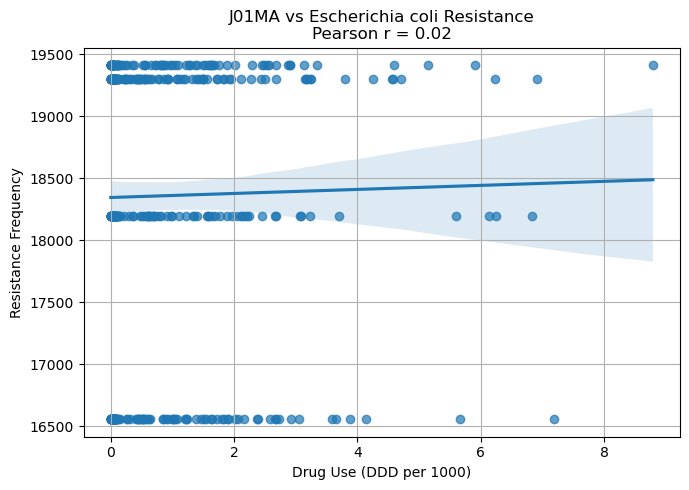

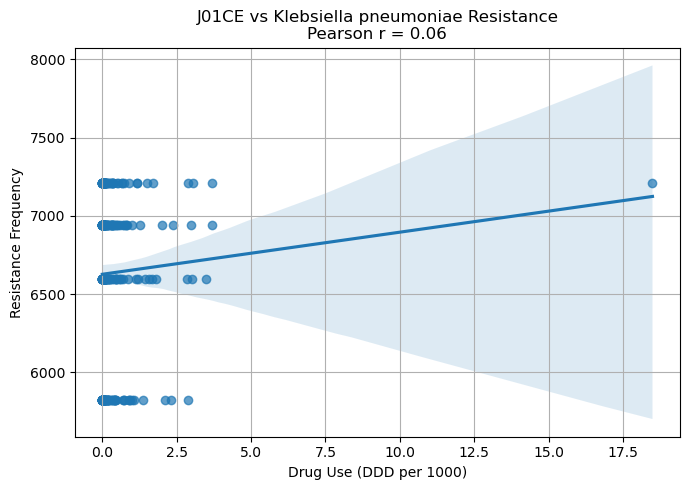


Fluoroquinolones (E. coli): r = 0.02
Beta-lactamase senstive penicillin (K. pneumoniae): r = 0.06


In [28]:
r1 = correlate_amu_resistance_return_r(amu_data, adult_yearly_df, 'J01MA', 'Escherichia coli', 'Adult')
r2 = correlate_amu_resistance_return_r(amu_data, adult_yearly_df, 'J01CE', 'Klebsiella pneumoniae', 'Adult')

print(f"\nFluoroquinolones (E. coli): r = {r1:.2f}")
print(f"Beta-lactamase senstive penicillin (K. pneumoniae): r = {r2:.2f}")


In [29]:
# Load the CARD metadata TSV file
aro_index_path = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\resistance_genes\\aro_index.tsv"  # replace with actual path
aro_index_df = pd.read_csv(aro_index_path, sep='\t')

# Select and rename relevant columns
card_mechanism_df = aro_index_df[[
    'ARO Accession',
    'Model Name',
    'ARO Name',
    'AMR Gene Family',
    'Drug Class',
    'Resistance Mechanism',
    'CARD Short Name'
]].copy()

# Drop duplicates and reset index
card_mechanism_df = card_mechanism_df.drop_duplicates().reset_index(drop=True)

# Preview the parsed dataset
card_mechanism_df.head(10)


,ARO Accession,Model Name,ARO Name,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
0,ARO:3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,23S rRNA (adenine(2058)-N(6))-methyltransferas...,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,Spyo_ErmA_MLSb
1,ARO:3002523,AAC(2')-Ia,AAC(2')-Ia,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ia
2,ARO:3002524,AAC(2')-Ib,AAC(2')-Ib,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ib
3,ARO:3002525,AAC(2')-Ic,AAC(2')-Ic,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ic
4,ARO:3002526,AAC(2')-Id,AAC(2')-Id,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Id
5,ARO:3002527,AAC(2')-Ie,AAC(2')-Ie,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ie
6,ARO:3004628,AAC(2')-IIa,AAC(2')-IIa,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-IIa
7,ARO:3003988,AAC(2')-IIb,AAC(2')-IIb,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-IIb
8,ARO:3002528,AAC(3)-Ia,AAC(3)-Ia,AAC(3),aminoglycoside antibiotic,antibiotic inactivation,AAC(3)-Ia
9,ARO:3002530,AAC(3)-Ib,AAC(3)-Ib,AAC(3),aminoglycoside antibiotic,antibiotic inactivation,AAC(3)-Ib


In [30]:
# Load the category index
aro_cat_path = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\resistance_genes\\aro_categories_index.tsv"  
aro_cat_df = pd.read_csv(aro_cat_path, sep='\t')

# Preview it
aro_cat_df.head()


,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism
0,AAB60941.1,AF002716.1,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration
1,AAA03550.1,L06156.2,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation
2,AAC44793.1,U41471.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation
3,CCP42991.1,AL123456.3,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation
4,AAB41701.1,U72743.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation


In [31]:
aro_cat_df.shape

(6403, 5)

In [32]:
aro_cat_df.columns

Index(['Protein Accession', 'DNA Accession', 'AMR Gene Family', 'Drug Class',
       'Resistance Mechanism'],
      dtype='object')

In [33]:
# Load the shortname_antibiotics.tsv file
shortname_abx_path = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\resistance_genes\\shortname_antibiotics.tsv"  
shortname_abx_df = pd.read_csv(shortname_abx_path, sep='\t')

# Preview
print("Shortname Antibiotics Dataset:")
print(shortname_abx_df.head())


Shortname Antibiotics Dataset:
  AAC Abbreviation         Molecule
0              AMG  Aminoglycosides
1              AMK         Amikacin
2              AMU    Aminocoumarin
3              AMX      Amoxicillin
4              ATM        Aztreonam


In [34]:
# Load the PMID.tsv file
pmid_path = "C:\\Users\\HP\\Desktop\\Learning Interests\\Projects\\AMR Surveillance Dashboard\\data\\resistance_genes\\PMID.tsv"  
pmid_df = pd.read_csv(pmid_path, sep='\t')

# Count number of supporting studies per ARO Accession
pmid_df['PMID Count'] = pmid_df['PMID'].apply(lambda x: len(str(x).split(';')) if pd.notnull(x) else 0)

# Preview
print("PMID Support Dataset:")
print(pmid_df[['ARO Accession', 'ARO Name', 'PMID Count']].head())


PMID Support Dataset:
  ARO Accession     ARO Name  PMID Count
0   ARO:3009134         Msh2           1
1   ARO:3000535         macB           3
2   ARO:0000049  kanamycin A           3
3   ARO:3002638  APH(3'')-Ia           1
4   ARO:3000895       TEM-25           2


In [35]:
# Drop duplicates on gene family in the flat file before joining
aro_cat_df_clean = aro_cat_df.drop_duplicates(subset=['AMR Gene Family'])

# Merge to enrich card_mechanism_df
card_enriched_df = pd.merge(
    card_mechanism_df,
    aro_cat_df_clean,
    on='AMR Gene Family',
    how='left'
)

# Preview the joined data
print("Final shape:", card_enriched_df.shape)
card_enriched_df.head(10)


Final shape: (6439, 11)


,ARO Accession,Model Name,ARO Name,AMR Gene Family,Drug Class_x,Resistance Mechanism_x,CARD Short Name,Protein Accession,DNA Accession,Drug Class_y,Resistance Mechanism_y
0,ARO:3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,23S rRNA (adenine(2058)-N(6))-methyltransferas...,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,Spyo_ErmA_MLSb,AAB60941.1,AF002716.1,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration
1,ARO:3002523,AAC(2')-Ia,AAC(2')-Ia,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ia,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
2,ARO:3002524,AAC(2')-Ib,AAC(2')-Ib,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ib,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
3,ARO:3002525,AAC(2')-Ic,AAC(2')-Ic,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ic,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
4,ARO:3002526,AAC(2')-Id,AAC(2')-Id,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Id,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
5,ARO:3002527,AAC(2')-Ie,AAC(2')-Ie,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ie,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
6,ARO:3004628,AAC(2')-IIa,AAC(2')-IIa,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-IIa,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
7,ARO:3003988,AAC(2')-IIb,AAC(2')-IIb,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-IIb,AAA03550.1,L06156.2,aminoglycoside antibiotic,antibiotic inactivation
8,ARO:3002528,AAC(3)-Ia,AAC(3)-Ia,AAC(3),aminoglycoside antibiotic,antibiotic inactivation,AAC(3)-Ia,AAG15269.1,U12338.3,aminoglycoside antibiotic,antibiotic inactivation
9,ARO:3002530,AAC(3)-Ib,AAC(3)-Ib,AAC(3),aminoglycoside antibiotic,antibiotic inactivation,AAC(3)-Ib,AAG15269.1,U12338.3,aminoglycoside antibiotic,antibiotic inactivation


In [36]:
aro_cat_df_clean.to_csv('aro_cat_clean_df.csv')

In [37]:
card_enriched_df.columns

Index(['ARO Accession', 'Model Name', 'ARO Name', 'AMR Gene Family',
       'Drug Class_x', 'Resistance Mechanism_x', 'CARD Short Name',
       'Protein Accession', 'DNA Accession', 'Drug Class_y',
       'Resistance Mechanism_y'],
      dtype='object')

In [38]:
# Decide which version to keep: we'll keep the left side (original)
card_cleaned_df = card_enriched_df.copy()

# Drop the duplicate columns from the right-side of the merge
card_cleaned_df = card_cleaned_df.drop(columns=['Drug Class_y', 'Resistance Mechanism_y'])

# Rename left-side columns to clean names
card_cleaned_df = card_cleaned_df.rename(columns={
    'Drug Class_x': 'Drug Class',
    'Resistance Mechanism_x': 'Resistance Mechanism'
})

# Final check
print("Final cleaned columns:")
print(card_cleaned_df.columns.tolist())

# Preview
card_cleaned_df.head()


Final cleaned columns:
['ARO Accession', 'Model Name', 'ARO Name', 'AMR Gene Family', 'Drug Class', 'Resistance Mechanism', 'CARD Short Name', 'Protein Accession', 'DNA Accession']


,ARO Accession,Model Name,ARO Name,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name,Protein Accession,DNA Accession
0,ARO:3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,23S rRNA (adenine(2058)-N(6))-methyltransferas...,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,Spyo_ErmA_MLSb,AAB60941.1,AF002716.1
1,ARO:3002523,AAC(2')-Ia,AAC(2')-Ia,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ia,AAA03550.1,L06156.2
2,ARO:3002524,AAC(2')-Ib,AAC(2')-Ib,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ib,AAA03550.1,L06156.2
3,ARO:3002525,AAC(2')-Ic,AAC(2')-Ic,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ic,AAA03550.1,L06156.2
4,ARO:3002526,AAC(2')-Id,AAC(2')-Id,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Id,AAA03550.1,L06156.2


In [39]:
card_cleaned_df.shape

card_cleaned_df.to_csv('card_cleaned_df.csv')

In [40]:
pmid_df['PMID Count'] = pmid_df['PMID'].apply(lambda x: len(str(x).split(';')) if pd.notnull(x) else 0)
pmid_df.head()

,ARO Accession,CVTERM ID,ARO Name,PMID,DOI,ISBN,PMID Count
0,ARO:3009134,47964,Msh2,27020939,NaN,NaN,1
1,ARO:3000535,36674,macB,16359323;12832048;19432486,NaN,NaN,3
2,ARO:0000049,35966,kanamycin A,11083623;8385262;10103173,NaN,NaN,3
3,ARO:3002638,39038,APH(3'')-Ia,2167474,NaN,NaN,1
4,ARO:3000895,37275,TEM-25,1929316;7840586,NaN,NaN,2


In [41]:
# Drop sparse columns from pmid_df before merge
pmid_df_clean = pmid_df.drop(columns=['ISBN', 'DOI'], errors='ignore')

# Confirm columns
print("Remaining columns in pmid_df:")
print(pmid_df_clean.columns.tolist())


Remaining columns in pmid_df:
['ARO Accession', 'CVTERM ID', 'ARO Name', 'PMID', 'PMID Count']


In [42]:
pmid_df_clean.head()

,ARO Accession,CVTERM ID,ARO Name,PMID,PMID Count
0,ARO:3009134,47964,Msh2,27020939,1
1,ARO:3000535,36674,macB,16359323;12832048;19432486,3
2,ARO:0000049,35966,kanamycin A,11083623;8385262;10103173,3
3,ARO:3002638,39038,APH(3'')-Ia,2167474,1
4,ARO:3000895,37275,TEM-25,1929316;7840586,2


In [43]:
#Merging the pmid cleaned dataframe with card_cleaned_df
card_lit_df = pd.merge(
    card_cleaned_df,
    pmid_df_clean[['ARO Accession', 'PMID', 'PMID Count']],
    on='ARO Accession',
    how='left'
)
card_lit_df.shape

(6439, 11)

In [44]:
card_lit_df.head()

,ARO Accession,Model Name,ARO Name,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name,Protein Accession,DNA Accession,PMID,PMID Count
0,ARO:3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,23S rRNA (adenine(2058)-N(6))-methyltransferas...,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,Spyo_ErmA_MLSb,AAB60941.1,AF002716.1,9527769,1.0
1,ARO:3002523,AAC(2')-Ia,AAC(2')-Ia,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ia,AAA03550.1,L06156.2,8407825,1.0
2,ARO:3002524,AAC(2')-Ib,AAC(2')-Ib,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ib,AAA03550.1,L06156.2,8891143,1.0
3,ARO:3002525,AAC(2')-Ic,AAC(2')-Ic,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ic,AAA03550.1,L06156.2,9159528,1.0
4,ARO:3002526,AAC(2')-Id,AAC(2')-Id,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Id,AAA03550.1,L06156.2,9159528,1.0


In [45]:
card_lit_df_with_support = card_lit_df[card_lit_df['PMID Count'] > 0]
card_lit_df_with_support.shape

(2723, 11)

In [46]:
card_lit_df['PMID Count'].unique()

array([ 1.,  2.,  3., nan,  5.,  4.,  9.,  7.,  6.,  0., 11., 10., 14.,
        8., 12., 13., 27., 22., 36.])

Modeling for mechanism based clustering

In [47]:
from sklearn.preprocessing import MultiLabelBinarizer

# Copy the dataframe to work on
df_cluster = card_lit_df_with_support.copy()

# Split drug classes and mechanisms into lists (some entries are comma-separated)
df_cluster['Drug Class'] = df_cluster['Drug Class'].fillna('').apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])
df_cluster['Resistance Mechanism'] = df_cluster['Resistance Mechanism'].fillna('').apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

# One-hot encode Drug Class
mlb_drug = MultiLabelBinarizer()
drug_ohe = pd.DataFrame(mlb_drug.fit_transform(df_cluster['Drug Class']),
                        columns=[f"Drug_{c}" for c in mlb_drug.classes_],
                        index=df_cluster.index)

# One-hot encode Resistance Mechanism
mlb_mech = MultiLabelBinarizer()
mech_ohe = pd.DataFrame(mlb_mech.fit_transform(df_cluster['Resistance Mechanism']),
                        columns=[f"Mech_{c}" for c in mlb_mech.classes_],
                        index=df_cluster.index)

# Combine encoded features
features_df = pd.concat([drug_ohe, mech_ohe], axis=1)

print("Shape of feature matrix for clustering:", features_df.shape)
features_df.head()


Shape of feature matrix for clustering: (2723, 176)


,Drug_aminocoumarin antibiotic,Drug_aminocoumarin antibiotic;aminoglycoside antibiotic,Drug_aminocoumarin antibiotic;aminoglycoside antibiotic;carbapenem;cephalosporin;diaminopyrimidine antibiotic;disinfecting agents and antiseptics;fluoroquinolone antibiotic;macrolide antibiotic;monobactam;penicillin beta-lactam;peptide antibiotic;phenicol antibiotic;sulfonamide antibiotic;tetracycline antibiotic,Drug_aminocoumarin antibiotic;aminoglycoside antibiotic;carbapenem;cephalosporin;diaminopyrimidine antibiotic;fluoroquinolone antibiotic;macrolide antibiotic;monobactam;penicillin beta-lactam;peptide antibiotic;phenicol antibiotic;sulfonamide antibiotic;tetracycline antibiotic,Drug_aminocoumarin antibiotic;aminoglycoside antibiotic;carbapenem;cephalosporin;disinfecting agents and antiseptics;fluoroquinolone antibiotic;glycylcycline;macrolide antibiotic;penicillin beta-lactam;peptide antibiotic;phenicol antibiotic;rifamycin antibiotic;tetracycline antibiotic,Drug_aminocoumarin antibiotic;aminoglycoside antibiotic;cephalosporin;diaminopyrimidine antibiotic;fluoroquinolone antibiotic;macrolide antibiotic;penicillin beta-lactam;phenicol antibiotic;tetracycline antibiotic,Drug_aminocoumarin antibiotic;carbapenem;cephalosporin;diaminopyrimidine antibiotic;fluoroquinolone antibiotic;macrolide antibiotic;monobactam;penicillin beta-lactam;peptide antibiotic;phenicol antibiotic;sulfonamide antibiotic;tetracycline antibiotic,Drug_aminocoumarin antibiotic;carbapenem;peptide antibiotic;rifamycin antibiotic,Drug_aminocoumarin antibiotic;cephalosporin;diaminopyrimidine antibiotic;fluoroquinolone antibiotic;macrolide antibiotic;penicillin beta-lactam;phenicol antibiotic;tetracycline antibiotic,Drug_aminocoumarin antibiotic;fluoroquinolone antibiotic,...,Mech_antibiotic inactivation,Mech_antibiotic inactivation;antibiotic target alteration,Mech_antibiotic target alteration,Mech_antibiotic target alteration;antibiotic target replacement,Mech_antibiotic target protection,Mech_antibiotic target replacement,Mech_reduced permeability to antibiotic,Mech_reduced permeability to antibiotic;resistance by absence,Mech_resistance by absence,Mech_resistance by host-dependent nutrient acquisition
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


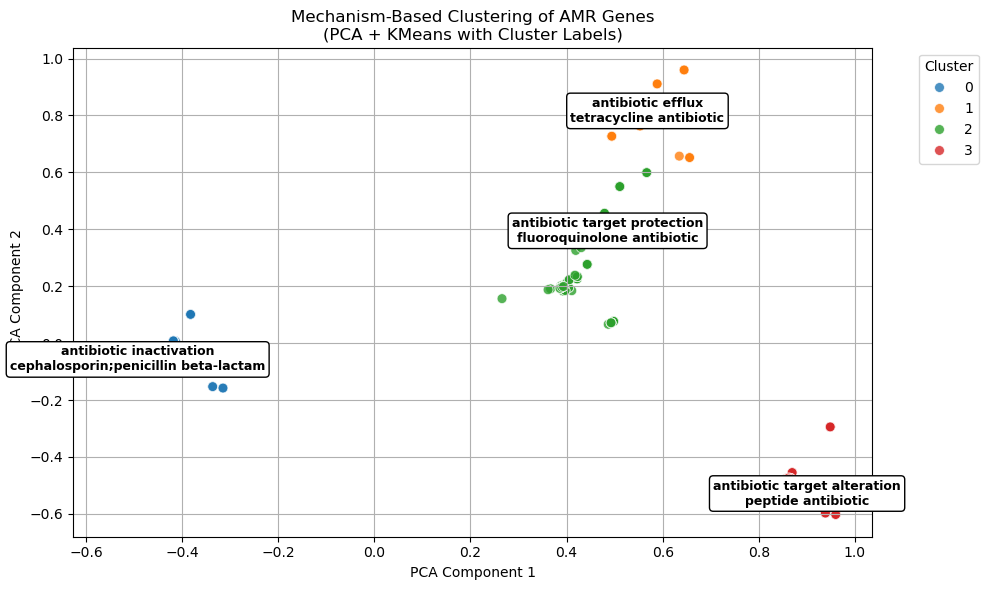

In [48]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Step 1: PCA for 2D
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(features_df)

# Step 2: KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_df)

# Step 3: Add to df_cluster
df_cluster['PCA1'] = pca_components[:, 0]
df_cluster['PCA2'] = pca_components[:, 1]
df_cluster['Cluster'] = clusters

# Step 4: Ensure lists are stringified
df_cluster['Resistance Mechanism'] = df_cluster['Resistance Mechanism'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)
df_cluster['Drug Class'] = df_cluster['Drug Class'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

# Step 5: Helper function to get top term
def get_top_term(series):
    items = ','.join(series.dropna()).split(',')
    items = [i.strip() for i in items if i.strip()]
    return Counter(items).most_common(1)[0][0] if items else None

# Step 6: Cluster-level summaries
mechanisms = df_cluster.groupby('Cluster')['Resistance Mechanism'].apply(get_top_term).rename("Dominant Mechanism")
drug_classes = df_cluster.groupby('Cluster')['Drug Class'].apply(get_top_term).rename("Dominant Drug Class")
centroids = df_cluster.groupby('Cluster')[['PCA1', 'PCA2']].mean()

# Combine into label frame
labels_df = pd.concat([centroids, mechanisms, drug_classes], axis=1).reset_index()
labels_df['Label'] = labels_df['Dominant Mechanism'] + "\n" + labels_df['Dominant Drug Class']

# Step 7: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=50, alpha=0.8)

# Add centroid labels
for _, row in labels_df.iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Label'],
             fontsize=9, weight='bold', ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

plt.title("Mechanism-Based Clustering of AMR Genes\n(PCA + KMeans with Cluster Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00       104

    accuracy                           1.00       545
   macro avg       1.00      1.00      1.00       545
weighted avg       1.00      1.00      1.00       545



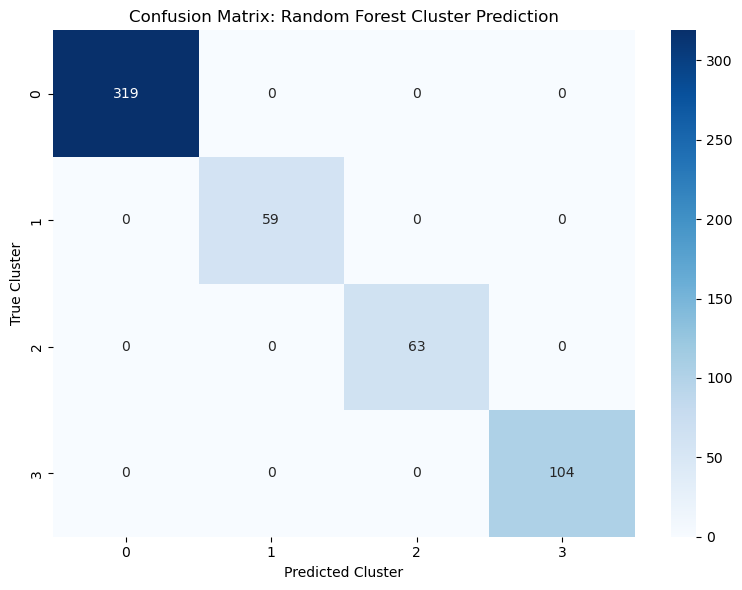

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare features and labels
X = features_df  # One-hot encoded drug classes and resistance mechanisms
y = df_cluster['Cluster']  # Target: cluster assignments

# Step 2: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 4: Predict on test set
y_pred = rf.predict(X_test)

# Step 5: Evaluate
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Step 6: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix: Random Forest Cluster Prediction")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_14804\3116946661.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
C:\Users\HP\AppData\Local\Temp\ipykernel_14804\3116946661.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


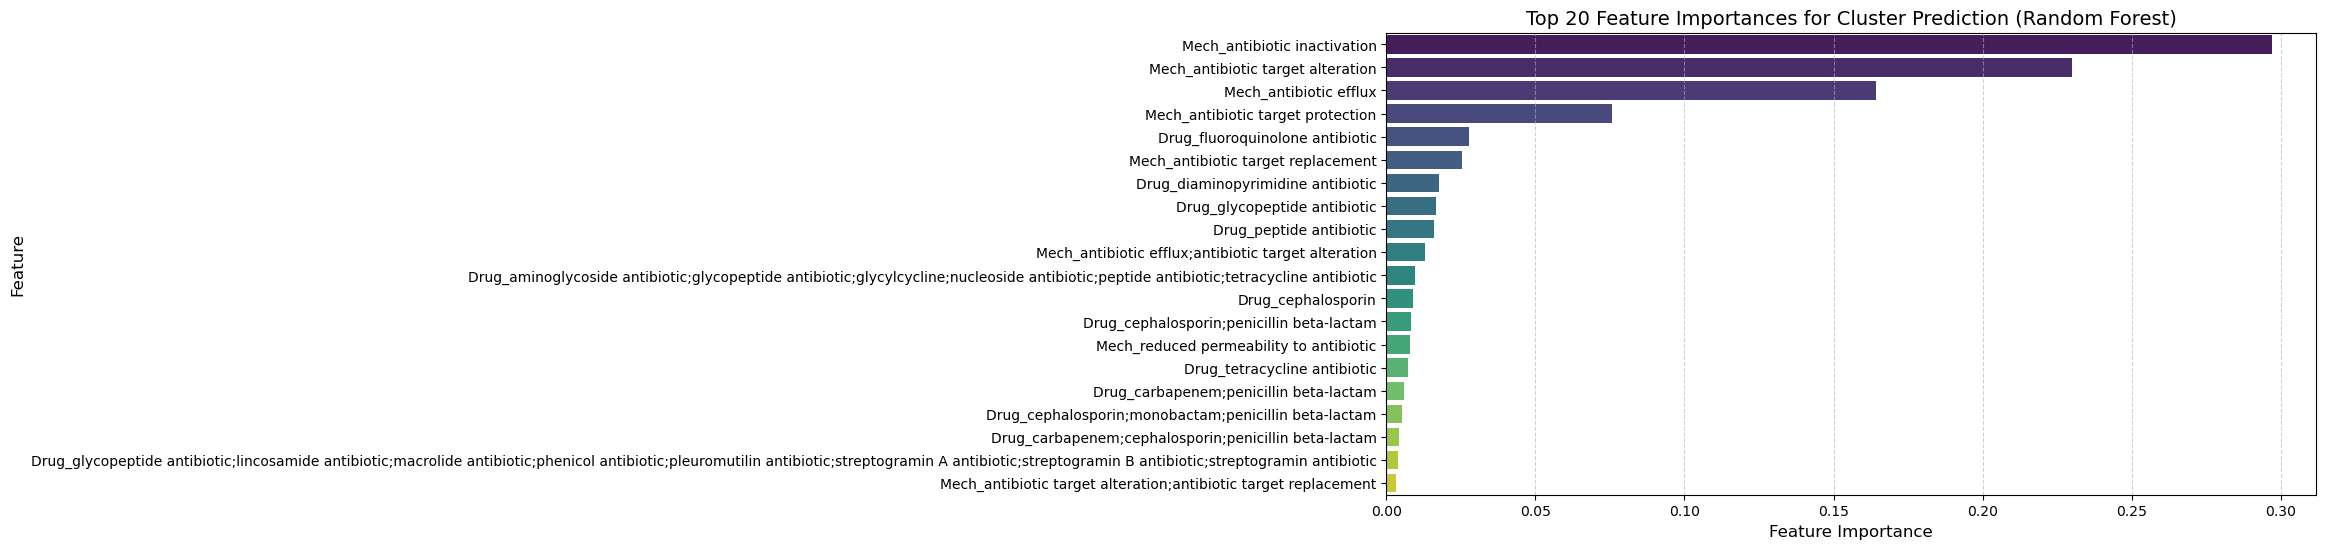

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Step 1: Prepare features and labels
X = features_df  # One-hot encoded resistance mechanisms + drug classes
y = df_cluster['Cluster']  # Cluster labels

# Step 2: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Step 3: Get feature importances
importances = rf.feature_importances_
feature_names = features_df.columns

# Step 4: Format into a DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 5: Plot top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=feat_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances for Cluster Prediction (Random Forest)", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [51]:
adult_yearly_df.to_csv('adult_yealy_df.csv')

In [52]:
pediatric_yearly_df.to_csv('pediatric_yearly_df.csv')

In [53]:
df_cluster.to_csv('df_cluster.csv')

In [54]:
feat_importance_df.to_csv('feat_importance_df.csv')